In [1]:
import xarray as xr
import numpy as np
from pathlib import Path
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import tqdm

## Filtrer mauvais profils

In [38]:
'''
tester flag code et verifier avec les quicklooks
enregistrer les quicklooks sur /scratchx/nmpnguyen/IPRAL/raw/
'''
def range_corrected_signal(signal_raw, opar_range, opar_alt, bck_correction = False):
    '''
    Fontionc permet de retrouver un signal corrigé de la distance à l'instrument et du fond ciel 
    Input: 
        signal_raw: raw signal (MHz) without any correction
        opar_range: range in meters 
        opar_alt: altitude in meters
        bck_correction: False = non corriger, True = corriger
    Output:
        Signal corrigé 
    '''
    if bck_correction == False:
        rcs = signal_raw * np.square(opar_range) #MHz.m^2
    else:
        idx = ((opar_alt>=80000)&(opar_alt<=100000))
        signal_bck = signal_raw.isel(range=idx)
        bck = signal_bck.mean(dim="range")
        rcs = (signal_raw - bck)*np.square(opar_range)
    return rcs


def filter_profile_file(raw, ch, limiteTop, limiteBottom):
    '''
    Critere 1: flagger si le signal en haut plus qu'en bas
    '''
    # 1. CORRIGER RANGE CORRECTED SIGNAL WITH BACKGROUND
    filecorrected = raw#range_corrected_signal(raw, raw['range']*1e3, raw['range']+2160, True)
    # 2. MEAN TOP AND BOTTOM SIGNAL
    limite = (raw['range']>limiteTop[0]) & (raw['range']<limiteTop[1])
    meanTop = filecorrected.isel(range=limite).mean(dim='range')
    limite = (raw['range']>limiteBottom[0]) & (raw['range']<limiteBottom[1])
    meanBottom = filecorrected.isel(range=limite).mean(dim='range')
    # 3. GETTING GOOD PROFILE
    index_mask = (meanTop-meanBottom)['signal'].values<0 #selectionner le profil correct
    return index_mask

def invalidated_profile(data):
    '''
    Critere 2: flagger si plus de 80% 0 valeurs dans un fichier de données
    '''
    nb_nonzero = np.count_nonzero(data>0, axis=1)
    nb_points_by_profile = data.shape[1]
    fraction_nonzero = nb_nonzero/nb_points_by_profile
    index_mask = fraction_nonzero > 0.5  #selectionner le profil correct    
    return index_mask

In [116]:
instr = 'LI1200'
OPAR_PATH = Path('/homedata/noel/OPAR/', instr+'.daily')
OPAR_LISTFILES = sorted(OPAR_PATH.glob("2020*.nc4"))
OUTPUT_PATH = Path('/scratchx/nmpnguyen/OPAR/raw/flag_test/')

range_limite_top = [26,28]
range_limite_bottom = [4,5]

In [117]:
file= OPAR_LISTFILES[0]
print(file)

/homedata/noel/OPAR/LI1200.daily/2020-01-07.nc4


In [132]:
dt = xr.open_dataset(file)
channel = '00355.o.Low'
filecorrectsignal = range_corrected_signal(dt.sel(channel='00355.o.Low'), dt['range'].values*1e3, dt['range'].values*1e3+2160, True)
limiteZ = (dt['range']>5)&(dt['range']<20)

idsmask = filter_profile_file(filecorrectsignal, channel, range_limite_top, range_limite_bottom)
idsmask1 = invalidated_profile(filecorrectsignal.isel(range=limiteZ)['signal'].values)

dateStart = pd.to_datetime(file.name.split('.')[0])
dateEnd = dateStart + pd.DateOffset(1)

In [133]:
np.where(idsmask), np.where(idsmask1)

((array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
          13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
          26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
          39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
          52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
          65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
          78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
          91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
         104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
         117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
         130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
         143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
         156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
         169, 170, 171, 172, 173, 174,

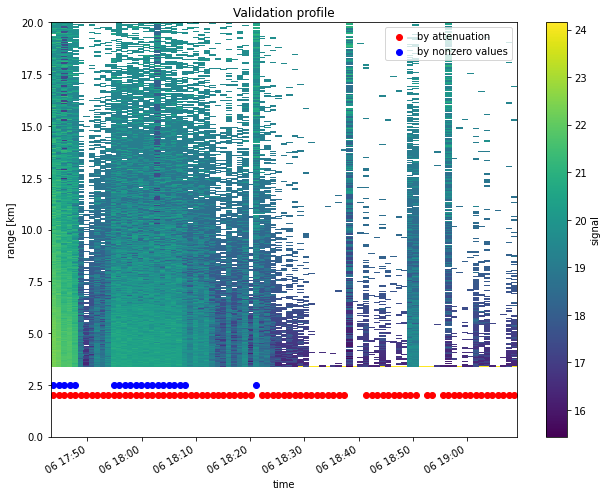

In [43]:
import warnings
warnings.filterwarnings("ignore")
fg, ax=plt.subplots(figsize=[9,7])
# RCS 12 : 355 ANALOG
# filecorrectsignal = range_corrected_signal(dt, dt['range']*1e3, dt['range']+2160, True)
np.log(filecorrectsignal.isel(range=limiteZ)['signal']).plot(x='time', y='range', ax=ax)
# ax.set_xlim(dateStart, dateEnd)
ax.scatter(dt['time'].values[idsmask], np.array([2]*len(dt['time'].values[idsmask])), color='r', label='by attenuation')
ax.scatter(dt['time'].values[idsmask1], np.array([2.5]*len(dt['time'].values[idsmask1])), color='b', label='by nonzero values')
ax.legend()
ax.set(title='Validation profile')
plt.tight_layout()
# plt.savefig(Path(OUTPUT_PATH, f'OPAR_{instr}_{channel}_{file.name.split(".")[0]}.png'))

### Histogramme des "nonzeros" QL

In [59]:
def nonzeros_fraction(data):
    nb_nonzero = np.count_nonzero(data, axis=1)
    nb_points_by_profile = data.shape[1]
    fraction_nonzero = nb_nonzero/nb_points_by_profile
    return fraction_nonzero

In [60]:
OPAR_LISTFILES = sorted(OPAR_PATH.glob("2020*.nc4"))
fraction_allQL = np.array([], dtype=('float'))
channel = '00355.o.Low'
for file in OPAR_LISTFILES:
    print(file)
    dt=xr.open_dataset(file)
    filecorrectsignal = range_corrected_signal(dt.sel(channel='00355.o.Low'), dt['range'].values*1e3, dt['range'].values*1e3+2160, True)
    limiteZ = np.where((dt['range']<20))[0]
    fraction_file = nonzeros_fraction(filecorrectsignal.isel(range=limiteZ)['signal'].values)
    fraction_allQL = np.concatenate([fraction_allQL, fraction_file])

/homedata/noel/OPAR/LI1200.daily/2020-01-07.nc4
/homedata/noel/OPAR/LI1200.daily/2020-01-13.nc4
/homedata/noel/OPAR/LI1200.daily/2020-01-27.nc4
/homedata/noel/OPAR/LI1200.daily/2020-01-28.nc4
/homedata/noel/OPAR/LI1200.daily/2020-02-03.nc4
/homedata/noel/OPAR/LI1200.daily/2020-02-04.nc4
/homedata/noel/OPAR/LI1200.daily/2020-02-11.nc4
/homedata/noel/OPAR/LI1200.daily/2020-02-17.nc4
/homedata/noel/OPAR/LI1200.daily/2020-02-18.nc4
/homedata/noel/OPAR/LI1200.daily/2020-02-19.nc4
/homedata/noel/OPAR/LI1200.daily/2020-03-06.nc4
/homedata/noel/OPAR/LI1200.daily/2020-03-10.nc4
/homedata/noel/OPAR/LI1200.daily/2020-03-12.nc4
/homedata/noel/OPAR/LI1200.daily/2020-03-16.nc4
/homedata/noel/OPAR/LI1200.daily/2020-06-02.nc4
/homedata/noel/OPAR/LI1200.daily/2020-06-08.nc4
/homedata/noel/OPAR/LI1200.daily/2020-06-15.nc4
/homedata/noel/OPAR/LI1200.daily/2020-06-16.nc4
/homedata/noel/OPAR/LI1200.daily/2020-06-22.nc4
/homedata/noel/OPAR/LI1200.daily/2020-06-23.nc4
/homedata/noel/OPAR/LI1200.daily/2020-06

[Text(0.5, 0, 'non-zero fraction par profil'),
 Text(0, 0.5, 'Counts'),
 Text(0.5, 1.0, '/homedata/noel/OPAR/LI1200.daily\n Histogramme des fractions non-zeros de 15851 profils')]

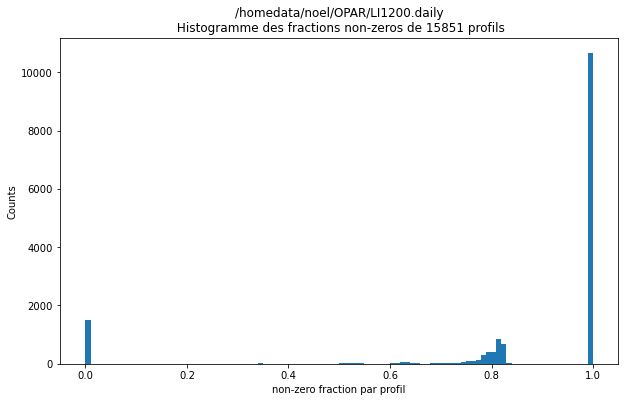

In [66]:
fig, ax = plt.subplots(figsize=[10,6])
H = ax.hist(np.array(fraction_allQL), bins=100)
ax.set(xlabel='non-zero fraction par profil', 
       ylabel='Counts',
       title=f'{OPAR_PATH}\n Histogramme des fractions non-zeros de {len(fraction_allQL)} profils')

## Dispersion Algorithm - Peak detection 

In [105]:
def wide_peak_finding(signal):
    # Input: signal in numpy array 
    peakIndex = []
    baseline = np.nanmean(signal)
    for value, index in zip(signal, range(len(signal))):
        if (value > baseline):
            peakIndex.append(index)
    return peakIndex

def dispersion_standard_deviation(signal, id_left, seuil, influence):
    '''
    signal : est un vecteur numpy
    id_left : le nombre de valeurs avant la valeur actuelle que nous voulons utiliser pour calculer la ligne de base mobile.
    seuil : le nombre d'écarts types par rapport à la ligne de base mobile qu'un pic doit dépasser pour être compté.
    influence : la quantité d'influence qu'un pic a sur la ligne de base mobile. Celui-ci doit être compris entre 0 et 1.
    '''
    peakIndex = []
    processedSignal = signal[0:id_left]
    for ids in range(id_left, len(signal)):
        y = signal[ids]
        avg = np.nanmean(processedSignal[id_left:ids])
        sd = np.std(processedSignal[id_left:ids])
        if ((y-avg) > (sd*seuil)):
            peakIndex.append(ids)
#             print(ids, len(processedSignal))
#             ajustedValued = (influence*y)+((1-influence)*processedSignal[ids-1])
        else:
            processedSignal = np.append(processedSignal, y)
    return peakIndex

def verification_by_SR(rawpath, instrument, ch, id_Z, mask_profiles):
    '''
    rawpath : le chemin du fichier Opar --> le nom du fichier 
    instrument : LI1200 ou LIO3T
    ch : channel du données 00355.o.Low ou 00355.o.VeryLow
    id_Z : indices des altitudes à étudier les nuages 
    mask_profiles : indices bool des nuages détectés à vérifier
    '''
    # Retrouver le fichier calibré correspondant 
    OPAR_RF_PATH = Path('/homedata/nmpnguyen/OPAR/Processed/RF/', instrument)
    OPAR_RF_FILE = Path(OPAR_RF_PATH, rawpath.name.split('.')[0]+'RF_v1.nc')
    # Caculer SR, range correspondant aux profiles à vérifier
    datacalib = xr.open_dataset(OPAR_RF_FILE)
    SR2Darray = (datacalib['calibrated']/datacalib['simulated']).isel(range=id_Z).sel(channel = ch).values
    Zlimite2Darray = np.array([datacalib['range'][id_Z].values] * len(datacalib['time']))
    # Retourner des indices indiqués les nuages 
    zcalib_top = datacalib.attrs['calibration height'][1]*1e-3
    selected_indices_profiles = np.where((np.ma.masked_array(SR2Darray, mask=mask_profiles)>1.7) & (np.ma.masked_array(Zlimite2Darray, mask=mask_profiles)<zcalib_top))
    final_indices_profiles = np.unique(selected_indices_profiles[0])
    return final_indices_profiles, zcalib_top
#

In [134]:
indices_profiles = np.zeros_like(filecorrectsignal.isel(range=limiteZ)['signal'].values, dtype=bool)
for t in range(len(dt['time'])):
    idsmask3 = dispersion_standard_deviation(filecorrectsignal.isel(time=t, range=limiteZ)['signal'].values,
                                           id_left = 5,
                                           seuil = 2,
                                           influence = 0.2) 
    indices_profiles[t,idsmask3] = True 

In [135]:
indices_profiles

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

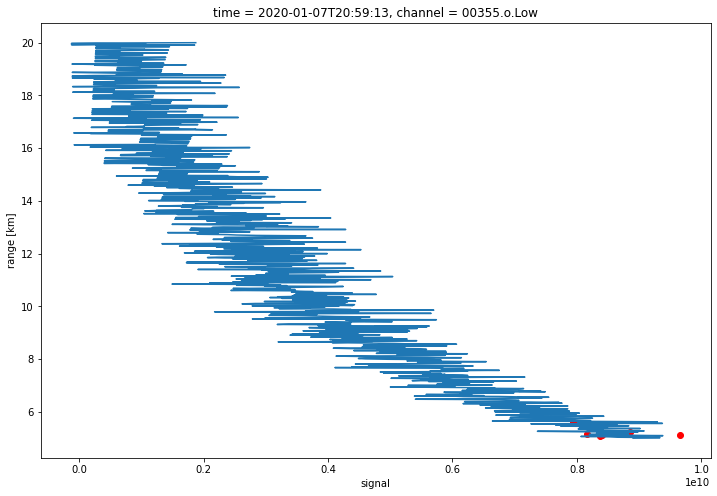

In [138]:
fg, ax = plt.subplots(figsize=[12,8])
filecorrectsignal.isel(time=t, range=limiteZ)['signal'].plot(y='range', ax=ax)
# xscatter = filecorrectsignal.isel(time=0, range=limiteZ)['signal'].values[result]
# yscatter = filecorrectsignal.isel(range=limiteZ)['range'][result]
# ax.scatter(xscatter, yscatter, color='g')
xscatter = filecorrectsignal.isel(time=0, range=limiteZ)['signal'].values[idsmask3]
yscatter = filecorrectsignal.isel(range=limiteZ)['range'][idsmask3]
ax.scatter(xscatter, yscatter, color='r')

In [139]:
indices_clouds_profiles, zcalib_top = verification_by_SR(file, instr, channel, limiteZ, indices_profiles)
indices_clouds_profiles = np.in1d(np.arange(len(dt['time'])), indices_clouds_profiles)
indices_clouds_profiles, zcalib_top

(array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True, False,  True,  True,  True,  True,  True,  True,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False,  True, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
      

In [141]:
idsmask_total = np.intersect1d(np.intersect1d(np.where(idsmask)[0], np.where(idsmask1)[0], return_indices=True)[0], 
                                np.where(~indices_clouds_profiles)[0], return_indices=True)[0]
idsmask_total

array([ 20,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       158, 160, 187, 188, 189, 190, 191, 192, 193])

## SR Histogram from time index of validated profiles

In [3]:
# instr='LIO3T'; channel='00532.p'
csv_lio3t = pd.read_csv(f'/scratchx/nmpnguyen/LIO3T_2020_00532.p_validated_profiles1.csv')
csv_li1200 = pd.read_csv(f'/scratchx/nmpnguyen/LI1200_2020_00355.o.Low_validated_profiles.csv')


In [5]:
def sr_by_files(csv_listdates, calib_pathfolder, wave):
    date_of_list = pd.to_datetime(csv_listdates.iloc[1]).strftime('%Y-%m-%d')
    file = sorted(calib_pathfolder.glob(f'{date_of_list}RF_v1.nc'))[0]
#     idfile = np.where([file.stem.split('_')[4] == str(date_of_list) for file in calib_listfiles])[0][0]
    datacalib = xr.open_dataset(file) #calib_listfiles[idfile]
    channel = '00532.p' if wave == 532 else '00355.o.Low'
    limiteZ = (datacalib['range']*1e3+2160>datacalib.attrs['calibration height'][0])&(datacalib['range']*1e3+2160<20000)
    indice = np.intersect1d(datacalib['time'].values, np.array(pd.to_datetime(csv_listdates)), return_indices=True)[1]
    sr_selected = (datacalib['calibrated']/datacalib['simulated']).sel(channel=channel).isel(time=indice, range=limiteZ)
    return sr_selected

def get_calibrated_data_by_datetime(datetime_profile, calib_path):
    date_of_list = pd.to_datetime(datetime_profile).strftime('%Y-%m-%d')
    print(date_of_list)
    # 532nm
    calib_listfiles = sorted(Path(calib_path, 'LIO3T').glob(f'{date_of_list}RF_v1.nc'))[0]
    print(calib_listfiles)
#         idfile = np.where([file.stem.split('_')[4] == str(date_of_list) for file in calib_listfiles])[0][0]
    channel = '00532.p'
    datacalib = xr.open_dataset(calib_listfiles).resample(time='15min').mean()
    limiteZ = (datacalib['range']+2.160>5)&(datacalib['range']+2.160<20)
    atb532 = datacalib['calibrated'].sel(time=datetime_profile,channel = channel).isel(range=limiteZ)
    sr532 = (datacalib['calibrated']/datacalib['simulated']).sel(time=datetime_profile,channel = channel).isel(range=limiteZ)
    # 355nm
    calib_listfiles = sorted(Path(calib_path, 'LI1200').glob(f'{date_of_list}RF_v1.nc'))[0]
    print(calib_listfiles)
    channel = '00355.o.Low'    
    datacalib = xr.open_dataset(calib_listfiles).resample(time='15min').mean()
    limiteZ = (datacalib['range']+2.160>5)&(datacalib['range']+2.160<20)
    atb355 = datacalib['calibrated'].sel(time=datetime_profile,channel = channel).isel(range=limiteZ)  
    sr355 = (datacalib['calibrated']/datacalib['simulated']).sel(time=datetime_profile,channel = channel).isel(range=limiteZ)
    return atb355, atb532, sr355, sr532 #

In [5]:
OPAR_RF_PATH = Path('/homedata/nmpnguyen/OPAR/Processed/RF/', 'LIO3T')
all_sr_selected_lio3t = sr_by_files(csv_lio3t.iloc[0], OPAR_RF_PATH, 532)
for i in range(1,csv_lio3t.shape[0]):
    try:
        sr_selected_lio3t = sr_by_files(csv_lio3t.iloc[i], OPAR_RF_PATH, 532)
        all_sr_selected_lio3t = xr.concat([all_sr_selected_lio3t, sr_selected_lio3t], dim='time')
    except:
        pass

In [6]:
OPAR_RF_PATH = Path('/homedata/nmpnguyen/OPAR/Processed/RF/', 'LI1200')
all_sr_selected_li1200 = sr_by_files(csv_li1200.iloc[0], OPAR_RF_PATH, 355)
for i in range(1,csv_lio3t.shape[0]):
    try:
        sr_selected_li1200 = sr_by_files(csv_li1200.iloc[i], OPAR_RF_PATH, 355)
        all_sr_selected_li1200 = xr.concat([all_sr_selected_li1200, sr_selected_li1200], dim='time')
    except:
        pass

In [6]:
all_sr_selected_li1200 = all_sr_selected_li1200.resample(time='2min').mean()
all_sr_selected_lio3t = all_sr_selected_lio3t.resample(time='2min').mean()

In [8]:
time_selected = np.intersect1d(all_sr_selected_li1200['time'].values, all_sr_selected_lio3t['time'].values)
range_selected = np.intersect1d(all_sr_selected_li1200['range'].values, all_sr_selected_lio3t['range'].values

In [31]:
Y355 = all_sr_selected_li1200.sel(time = time_selected, range=range_selected)#.values
X532 = all_sr_selected_lio3t.sel(time = time_selected, range=range_selected)#.values
# X532 = all_sr_selected_lio3t.sel(time = time_selected).values
# np.nanmean(np.reshape(np.array(X532), (X532.shape[0], int(X532.shape[1]/2), 2)), axis=2)

In [34]:
# all_sr_selected_li1200['range'], all_sr_selected_lio3t['range'].values.reshape(-1,2)

all_sr_selected_lio3t.sel(time = time_selected).values[:100,:]

MemoryError: Unable to allocate 3.09 GiB for an array with shape (207460, 2000) and data type float64

In [150]:
from matplotlib.colors import LogNorm
from scipy import stats

slope, intercept, r_value, p_value, std_err = stats.linregress(X532.ravel(), Y355.ravel())
fitLine = slope * X532.ravel() + intercept


In [42]:
# sr355tohist = xr.open_dataset('/scratchx/nmpnguyen/OPAR/raw/SR_histogram/355_sr_to_histogram.nc')
# sr532tohist = xr.open_dataset('/scratchx/nmpnguyen/OPAR/raw/SR_histogram/532_sr_to_histogram.nc')

In [45]:
# X532 = sr532tohist['__xarray_dataarray_variable__'].values
# Y355 = sr355tohist['__xarray_dataarray_variable__'].values

In [151]:
H = np.histogram2d(X532.ravel(), Y355.ravel(), bins=100,
                  range = [[0, 100], [0, 100]])
Hprobas = H[0]/len(X532.ravel())*100
Xxedges, Yyedges = np.meshgrid(H[1], H[2])

MemoryError: Unable to allocate 1.46 GiB for an array with shape (196464620,) and data type int64

In [ ]:
from matplotlib.colors import LogNorm
ff, (ax, axins) = plt.subplots(figsize=[6,10], nrows=2)
p = ax.pcolormesh(Xxedges, Yyedges, Hprobas.T, norm = LogNorm(vmax=1e0, vmin=1e-6)) #
c = plt.colorbar(p, ax=ax, label='%')
ax.set(xlabel='SR532', ylabel='SR355')
# ax.plot(X532.ravel()[ids], fitLine, c='r') #Fit line
ax.set_xlim(0,100)
ax.set_ylim(0,100)

# pins = axins.pcolormesh(Xxedges, Yyedges, Hprobas.T, norm = LogNorm(vmax=1e-02, vmin=1e-6))
# cins = plt.colorbar(pins, ax=axins, label='%')
# axins.set_ylim(0, 20)
# axins.set_xlim(0, 20)
# axins.set(xlabel='SR532', ylabel='SR355')
# # Add a footnote below and to the right side of the chart
# axins.annotate(footnote355+'\n'+footnote532,
#             xy = (1.0, -0.2),
#             xycoords='axes fraction',
#             ha='right',
#             va="center",
#             fontsize=10)
ff.tight_layout()

In [32]:
# np.unique(np.where(X532 > 15*Y355)[0])
ids_bug = np.where(X532 > 15*Y355)
# print(sr355tohist.isel(time=np.unique(ids_bug[0]))['time'])
# time_bug = sr355tohist.isel(time=np.unique(ids_bug[0]))['time']
time_bug = X532.isel(time=np.unique(ids_bug[0]))['time']
print(time_bug)

<xarray.DataArray 'time' (time: 742)>
array(['2020-02-11T18:14:00.000000000', '2020-02-11T18:16:00.000000000',
       '2020-02-11T18:20:00.000000000', ..., '2020-10-27T20:36:00.000000000',
       '2020-10-27T20:40:00.000000000', '2020-10-27T20:42:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2020-02-11T18:14:00 ... 2020-10-27T20:42:00
    channel  <U7 '00532.p'


In [7]:
# np.unique(pd.to_datetime(time_bug.values).strftime('%Y%m%d'))

def get_calibrated_data_by_datetime(datetime_profile, calib_path, time_freq, channel):
    date_of_list = pd.to_datetime(datetime_profile).strftime('%Y-%m-%d')
    print(date_of_list)
    # 532nm
    calib_listfiles = sorted(Path(calib_path, 'LIO3T').glob(f'{date_of_list}RF_v1.nc'))[0]
    print(calib_listfiles)
#         idfile = np.where([file.stem.split('_')[4] == str(date_of_list) for file in calib_listfiles])[0][0]
    channel = channel532
#     datacalib = xr.open_dataset(calib_listfiles).resample(time=time_freq).mean() #average with time freq
    datacalib = xr.open_dataset(calib_listfiles)
    id_selectedtime = np.where(datacalib.time.dt.round('1MIN') == datetime_profile)[0]
    limiteZ = (datacalib['range']+2.160>5)&(datacalib['range']+2.160<20)
    atb532 = datacalib['calibrated'].sel(channel = channel).isel(time=id_selectedtime,range=limiteZ)
    atb532mol = datacalib['simulated'].sel(channel = channel).isel(time=id_selectedtime,range=limiteZ)
#     sr532 = (datacalib['calibrated']/datacalib['simulated']).sel(time=datetime_profile,channel = channel).isel(range=limiteZ)
    # 355nm
    calib_listfiles = sorted(Path(calib_path, 'LI1200').glob(f'{date_of_list}RF_v1.nc'))[0]
    print(calib_listfiles)
    channel = '00355.o.Low'    
#     datacalib = xr.open_dataset(calib_listfiles).resample(time=time_freq).mean() #average with time freq
    datacalib = xr.open_dataset(calib_listfiles)
    id_selectedtime = np.where(datacalib.time.dt.round('1MIN') == datetime_profile)[0]
    limiteZ = (datacalib['range']+2.160>5)&(datacalib['range']+2.160<20)
    atb355 = datacalib['calibrated'].sel(time=datetime_profile,channel = channel).isel(range=limiteZ)  
    atb355mol = datacalib['simulated'].sel(time=datetime_profile,channel = channel).isel(range=limiteZ)  
#     sr355 = (datacalib['calibrated']/datacalib['simulated']).sel(time=datetime_profile,channel = channel).isel(range=limiteZ)
    return atb355, atb532, atb355mol, atb532mol#sr355, sr532

def get_calibrated_signal_by_datetime(datetime_profile, lidar, time_freq, channel_profile):
    date_of_file = pd.to_datetime(datetime_profile).strftime('%Y-%m-%d')
    print(date_of_file)
    calib_listfiles = sorted(Path('/homedata/nmpnguyen/OPAR/Processed/RF/', lidar).glob(f'{date_of_file}RF_v1.nc'))[0]
    datacalib = xr.open_dataset(calib_listfiles)
    id_selectedtime = (datacalib.time.dt.round(time_freq) == datetime_profile)
    limiteZ = (datacalib['range']+2.160>5)&(datacalib['range']+2.160<20)
    atb_profile = datacalib['calibrated'].sel(channel = channel_profile).isel(time=id_selectedtime,range=limiteZ)
    atbmol_profile = datacalib['simulated'].sel(channel = channel_profile).isel(time=id_selectedtime,range=limiteZ)
    return atb_profile, atbmol_profile
    

In [90]:
atb_355_bug, atb_532_bug_p,  atb_355_mol, atb_532_mol= get_calibrated_data_by_datetime(np.array('2020-03-16T19:10:00.000000000', dtype='datetime64[ns]'), 
                                                                                            '/homedata/nmpnguyen/OPAR/Processed/RF/', 
                                                                                            '2min', '00532.p')
atb_355_bug, atb_532_bug_s,  atb_355_mol, atb_532_mol = get_calibrated_data_by_datetime(np.array('2020-03-16T19:15:00.000000000', dtype='datetime64[ns]'), 
                                                                                            '/homedata/nmpnguyen/OPAR/Processed/RF/', 
                                                                                            '1min', '00532.s')


range_intersect = np.intersect1d(atb_355_bug['range'].values, atb_532_bug_p['range'].values, return_indices=True)[0]



2020-03-16
2020-03-16


In [45]:
reshape532s = atb_532_bug_s.values.reshape(int(2000/4),4).mean(axis=1)
reshape532p = atb_532_bug_p.values.reshape(int(2000/4),4).mean(axis=1)
reshape355 = atb_355_bug.values.reshape(int(1000/2),2).mean(axis=1)
reshapeZ = atb_355_bug['range'].values.reshape(int(1000/2),2).mean(axis=1)


atb_355_mol['range'].values.reshape(int(1000/2),2).mean(axis=1), atb_532_mol['range'].values.reshape(int(2000/4),4).mean(axis=1)


(array([ 2.8575,  2.8875,  2.9175,  2.9475,  2.9775,  3.0075,  3.0375,
         3.0675,  3.0975,  3.1275,  3.1575,  3.1875,  3.2175,  3.2475,
         3.2775,  3.3075,  3.3375,  3.3675,  3.3975,  3.4275,  3.4575,
         3.4875,  3.5175,  3.5475,  3.5775,  3.6075,  3.6375,  3.6675,
         3.6975,  3.7275,  3.7575,  3.7875,  3.8175,  3.8475,  3.8775,
         3.9075,  3.9375,  3.9675,  3.9975,  4.0275,  4.0575,  4.0875,
         4.1175,  4.1475,  4.1775,  4.2075,  4.2375,  4.2675,  4.2975,
         4.3275,  4.3575,  4.3875,  4.4175,  4.4475,  4.4775,  4.5075,
         4.5375,  4.5675,  4.5975,  4.6275,  4.6575,  4.6875,  4.7175,
         4.7475,  4.7775,  4.8075,  4.8375,  4.8675,  4.8975,  4.9275,
         4.9575,  4.9875,  5.0175,  5.0475,  5.0775,  5.1075,  5.1375,
         5.1675,  5.1975,  5.2275,  5.2575,  5.2875,  5.3175,  5.3475,
         5.3775,  5.4075,  5.4375,  5.4675,  5.4975,  5.5275,  5.5575,
         5.5875,  5.6175,  5.6475,  5.6775,  5.7075,  5.7375,  5.7675,
      

In [10]:
dtoo = xr.open_dataset('/homedata/nmpnguyen/OPAR/Processed/RF/LIO3T/2020-03-16V0532o.nc')
dtoo = dtoo.resample(time='2min').mean()
print(dtoo)
limiteZ = (dtoo['range']+2.160>5)&(dtoo['range']+2.160<20)
datetimeprofile = np.array('2020-03-16T18:30:00.000000000', dtype='datetime64[ns]')
atb_532_bug_o = dtoo['calibrated'].sel(time=datetimeprofile).isel(range=limiteZ, channel=0)  
atb_532_bug_oo = dtoo['calibrated'].sel(time=datetimeprofile).isel(range=limiteZ, channel=1) 

reshape532o = atb_532_bug_o.values.reshape(int(2000/4),4).mean(axis=1)
reshape532oo = atb_532_bug_oo.values.reshape(int(2000/4),4).mean(axis=1)

<xarray.Dataset>
Dimensions:     (channel: 2, range: 16380, time: 130)
Coordinates:
  * time        (time) datetime64[ns] 2020-03-16T16:18:00 ... 2020-03-16T20:3...
  * range       (range) float64 0.0 0.0075 0.015 0.0225 ... 122.8 122.8 122.8
  * channel     (channel) object '00532.o' '00532.o'
Data variables:
    calibrated  (time, channel, range) float64 0.0 -1.914e-11 ... 0.0008484
    simulated   (time, channel, range) float64 1.231e-06 1.23e-06 ... -4.66e-08


Text(0.5, 0.98, 'time = 2020-03-16T18:30:00.000000000')

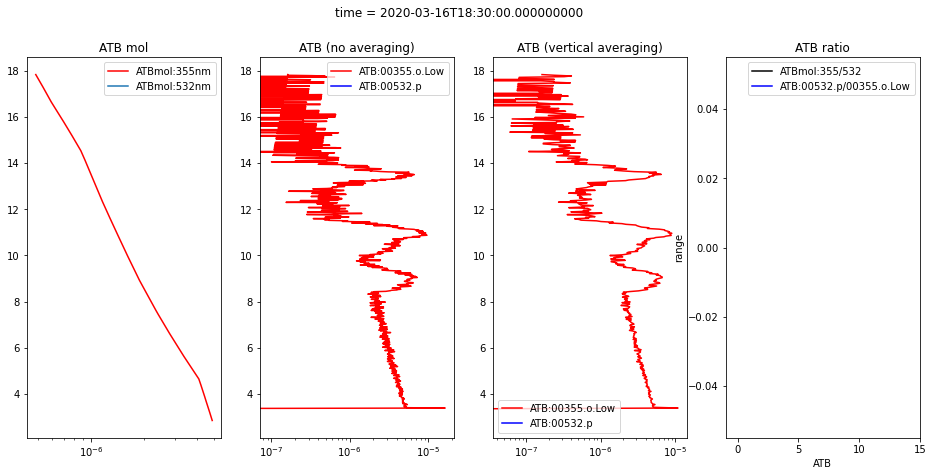

In [46]:
fff, (ax, ax3, ax4, ax2) = plt.subplots(figsize=[16,7], ncols=4)
ax.semilogx(atb_355_mol, atb_355_mol['range'].values, label='ATBmol:355nm', color='red')
ax.semilogx(atb_532_mol, atb_532_mol['range'].values, label='ATBmol:532nm')
ax.legend(loc='best')
ax.set(title='ATB mol')

(atb_532_mol.sel(range=range_intersect)/atb_355_mol.sel(range=range_intersect)).plot(y='range', label='ATBmol:355/532', ax=ax2, color='k', zorder=10)
ax2.plot(reshape532p/reshape355, reshapeZ, label='ATB:00532.p/00355.o.Low', color='blue')
# ax2.plot(reshape532s/reshape355, reshapeZ, label='ATB:00532.s/00355.o.Low', color='orange')
# ax2.plot(reshape532o/reshape355, reshapeZ, label='ATB:00532.o(4)/00355.o.Low', color='green')
# ax2.plot(reshape532oo/reshape355, reshapeZ, label='ATB:00532.o(5)/00355.o.Low', color='purple')
ax2.legend(loc='best')
ax2.set(xlabel='ATB', title='ATB ratio')
ax2.set_xlim(-1,15)

# np.log(atb_355_bug).plot(y='range', label='ATB:00355.o.Low', ax=ax3, color='red')
# np.log(atb_532_bug_p).plot(y='range', label='ATB:00532.p', ax=ax3)
# np.log(atb_532_bug_s).plot(y='range', label='ATB:00532.s', ax=ax3)
# # np.log(atb_532_bug_o).plot(y='range', label='ATB:00532.o', ax=ax3)
# ax3.semilogx(atb_532_bug_o.values, atb_532_bug_o['range'].values, label='ATB:00532.o', ax=ax3)
# ax3.semilogx(atb_532_bug_oo.values, atb_532_bug_oo['range'].values, label='ATB:00532.oo', ax=ax3)
# # np.log(atb_532_bug_oo).plot(y='range', label='ATB:00532.oo', ax=ax3)
# ax3.set(title='ATB (no averaging)')
# ax3.legend(loc='best')

ax3.semilogx(atb_355_bug, atb_355_bug['range'].values, label='ATB:00355.o.Low', color='red')
ax3.semilogx(atb_532_bug_p, atb_532_bug_p['range'].values, label='ATB:00532.p', color='blue')
# ax3.semilogx(atb_532_bug_s, atb_532_bug_s['range'].values, label='ATB:00532.s', color='orange')
# ax3.semilogx(atb_532_bug_o, atb_532_bug_o['range'].values, label='ATB:00532.o(4)', color='green')
# ax3.semilogx(atb_532_bug_oo, atb_532_bug_oo['range'].values, label='ATB:00532.o(5)', color='purple')
ax3.set(title='ATB (no averaging)')
ax3.legend(loc='best')

ax4.semilogx((reshape355), reshapeZ, label='ATB:00355.o.Low', color='red')
ax4.semilogx((reshape532p), reshapeZ, label='ATB:00532.p', color='blue')
# ax4.semilogx((reshape532s), reshapeZ, label='ATB:00532.s', color='orange')
# ax4.semilogx((reshape532o), reshapeZ, label='ATB:00532.o(4)', color='green')
# ax4.semilogx((reshape532oo), reshapeZ, label='ATB:00532.o(5)', color='purple')
ax4.set(title='ATB (vertical averaging)')
ax4.legend(loc='best')

plt.suptitle(f'time = 2020-03-16T18:30:00.000000000')

/mnt/homedafs-2.5/lov/homedata/nmpnguyen/python_envs/ipral_tools/lib/python3.8/site-packages/xarray/core/computation.py:724: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)
/mnt/homedafs-2.5/lov/homedata/nmpnguyen/python_envs/ipral_tools/lib/python3.8/site-packages/xarray/core/computation.py:724: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)
/mnt/homedafs-2.5/lov/homedata/nmpnguyen/python_envs/ipral_tools/lib/python3.8/site-packages/xarray/core/computation.py:724: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)
/mnt/homedafs-2.5/lov/homedata/nmpnguyen/python_envs/ipral_tools/lib/python3.8/site-packages/xarray/core/computation.py:724: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)


Text(0.5, 0.98, 'Range corrected signal')

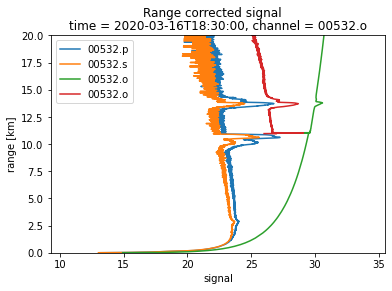

In [98]:
# dtraw = xr.open_dataset('/homedata/noel/OPAR/LIO3T.daily/2020-03-16.nc4').resample(time='2min').mean()
np.log(dtraw['signal'].isel(channel=6).sel(time='2020-03-16T18:30:00.000000000')*np.square(dtraw['range'].values*1e3)).plot(y='range', ylim=(0,20), 
                                                                                                                            label=f'{dtraw.channel.values[6]}')
np.log(dtraw['signal'].isel(channel=7).sel(time='2020-03-16T18:30:00.000000000')*np.square(dtraw['range'].values*1e3)).plot(y='range', ylim=(0,20),
                                                                                                                           label=f'{dtraw.channel.values[7]}')
np.log(dtraw['signal'].isel(channel=4).sel(time='2020-03-16T18:30:00.000000000')*np.square(dtraw['range'].values*1e3)).plot(y='range', ylim=(0,20),
                                                                                                                           label=f'{dtraw.channel.values[4]}')
np.log(dtraw['signal'].isel(channel=5).sel(time='2020-03-16T18:30:00.000000000')*np.square(dtraw['range'].values*1e3)).plot(y='range', ylim=(0,20),
                                                                                                                           label=f'{dtraw.channel.values[5]}')
plt.legend()
plt.suptitle('Range corrected signal')

In [73]:
dt = xr.open_dataset('/homedata/nmpnguyen/IPRAL/RF/Calibrated/ipral_1a_Lz1R15mF30sPbck_v01_20180224_000000_1440.nc')
dt

<xarray.Dataset>
Dimensions:     (range: 4000, time: 2845, wavelength: 2)
Coordinates:
  * time        (time) datetime64[ns] 2018-02-23T23:59:54.000000256 ... 2018-...
  * range       (range) float32 15.0 30.0 45.0 ... 5.997e+04 5.998e+04 6e+04
  * wavelength  (wavelength) int64 355 532
Data variables:
    calibrated  (wavelength, time, range) float64 ...
    simulated   (wavelength, time, range) float64 ...
Attributes:
    calibration height:  [5000 7000]
    canal:               ['355-analog-NearField', '532-analog-NearField']
    Ipral_canal:         ['rcs_12', 'rcs_16']

Text(0.5, 0.98, 'IPRAL /homedata/nmpnguyen/IPRAL/RF/Calibrated/ipral_1a_Lz1R15mF30sPbck_v01_20180224_000000_1440.nc \n2018-02-24T21:05:17.999999744')

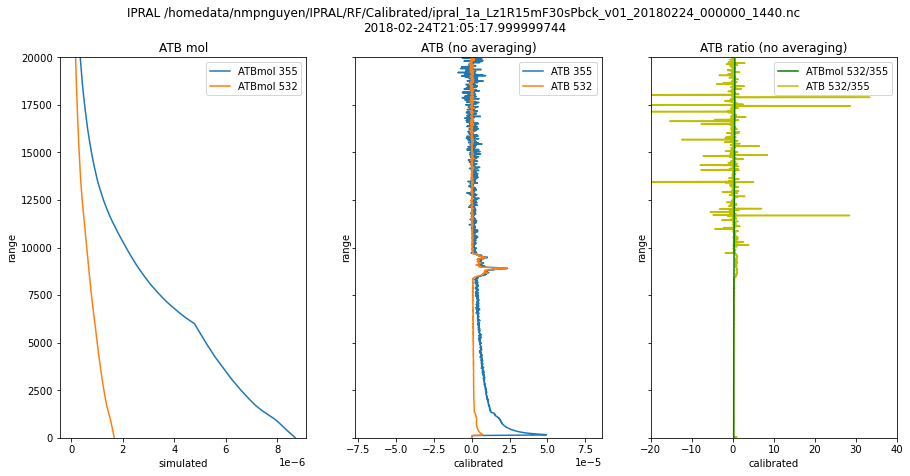

In [78]:
fff, (ax, ax3, ax2) = plt.subplots(figsize=[15,7], ncols=3, sharey=True)
dt.sel(wavelength=355).isel(time=2500)['simulated'].plot(y='range', label='ATBmol 355', ax=ax)
dt.sel(wavelength=532).isel(time=2500)['simulated'].plot(y='range', label='ATBmol 532', ax=ax)
ax.legend()
ax.set_ylim(0,20000)
ax.set(title='ATB mol')

# (dt.sel(wavelength=355).isel(time=2500)['calibrated']/dt.sel(wavelength=355).isel(time=2500)['simulated']).plot(y='range', label='ATB 355', ax=ax2)
# (dt.sel(wavelength=532).isel(time=2500)['calibrated']/dt.sel(wavelength=532).isel(time=2500)['simulated']).plot(y='range', label='ATB 532', ax=ax2)
(dt.sel(wavelength=532).isel(time=2500)['simulated']/dt.sel(wavelength=355).isel(time=2500)['simulated']).plot(y='range', label='ATBmol 532/355', ax=ax2, color='g', zorder=10)
(dt.sel(wavelength=532).isel(time=2500)['calibrated']/dt.sel(wavelength=355).isel(time=2500)['calibrated']).plot(y='range', label='ATB 532/355', ax=ax2, color='y')

ax2.legend()
ax2.set_xlim(-20,40)
ax2.set(title='ATB ratio (no averaging)')

dt.sel(wavelength=355).isel(time=2500)['calibrated'].plot(y='range', label='ATB 355', ax=ax3)
dt.sel(wavelength=532).isel(time=2500)['calibrated'].plot(y='range', label='ATB 532', ax=ax3)
ax3.legend()
ax3.set(title='ATB (no averaging)')

plt.suptitle(f'IPRAL /homedata/nmpnguyen/IPRAL/RF/Calibrated/ipral_1a_Lz1R15mF30sPbck_v01_20180224_000000_1440.nc \n{str(dt.time.values[2500])}')

### zommer le cas 2020-03-16 pour découvrir le décalage temporel 

In [155]:

dt532 = xr.open_dataset('/homedata/noel/OPAR/LIO3T.daily/2020-10-27.nc4')
dt355 = xr.open_dataset('/homedata/noel/OPAR/LI1200.daily/2020-10-27.nc4')
TimeStart = pd.to_datetime(':00:00')
TimeEnd = pd.to_datetime('2020-10-27 21:15:00')

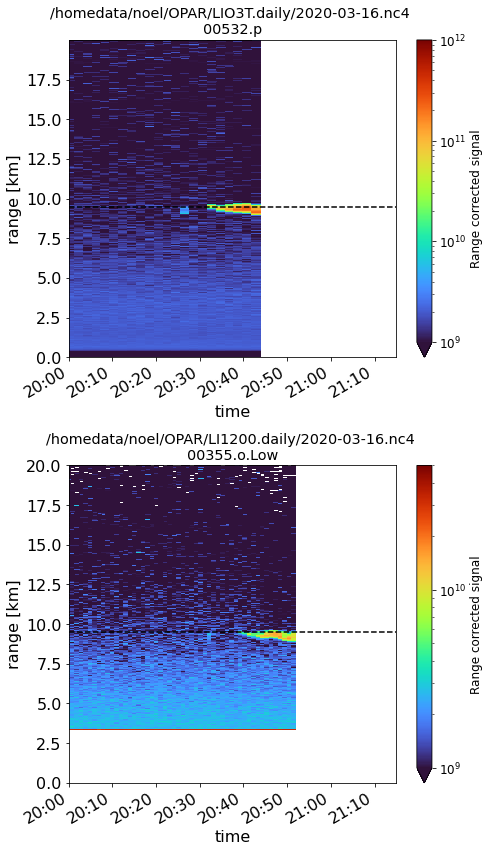

In [156]:
import matplotlib.dates as mdates
from matplotlib.colors import LogNorm

zclouds = 9.5
fig, (ax, ax2) = plt.subplots(nrows=2, figsize = (7,12))
plt.rcParams['font.size'] = '12'
plt.rcParams['axes.labelsize'] = '12'

limiteZ = dt532['range']<20
(dt532['signal']*np.square(dt532['range']*1e3)).isel(channel=6, range=limiteZ).plot(x='time', y='range', ax=ax, cmap='turbo', norm=LogNorm(vmin=1e9, vmax=1e12),
                                                                                         robust=True, cbar_kwargs={'label':'Range corrected signal'})
ax.axhline(zclouds,color='k', linestyle ="--")
ax.set_xlim(TimeStart, TimeEnd)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.set(title='/homedata/noel/OPAR/LIO3T.daily/2020-03-16.nc4 \n00532.p')

limiteZ = dt355['range']<20
(dt355['signal']*np.square(dt355['range']*1e3)).isel(channel=5, range=limiteZ).plot(x='time', y='range', ax=ax2, cmap='turbo', norm=LogNorm(vmin=1e9, vmax=0.5e11),
                                                                                         robust=True, cbar_kwargs={'label':'Range corrected signal'})
ax2.axhline(zclouds,color='k', linestyle ="--")
ax2.set_xlim(TimeStart, TimeEnd)
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax2.set(title='/homedata/noel/OPAR/LI1200.daily/2020-03-16.nc4 \n00355.o.Low')
plt.tight_layout()

2020-10-27
2020-10-27


[Text(0.5, 0, 'ATB (km-1.sr-1)'), Text(0, 0.5, 'range(km)')]

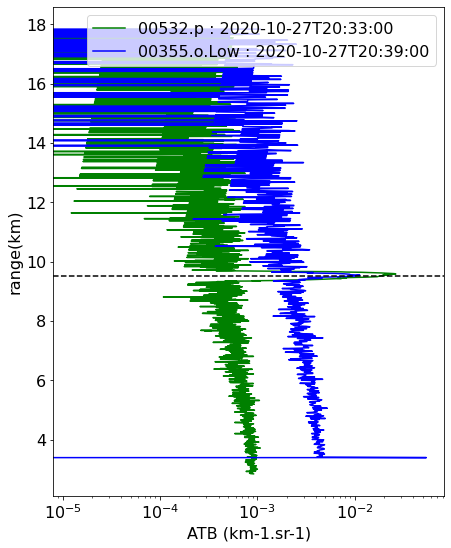

In [159]:
profile532 = np.array('2020-10-27T20:33:00.000000000', dtype='datetime64[ns]')
profile355 = np.array('2020-10-27T20:39:00.000000000', dtype='datetime64[ns]')

atb_355_bug, atb_355_mol = get_calibrated_signal_by_datetime(datetime_profile=profile355, 
                                                             lidar='LI1200', 
                                                             time_freq='1MIN', 
                                                             channel_profile='00355.o.Low')
atb_532_bug_p, atb_532_mol = get_calibrated_signal_by_datetime(datetime_profile=profile532, 
                                                             lidar='LIO3T', 
                                                             time_freq='1MIN', 
                                                             channel_profile='00532.p')
fig, ax = plt.subplots(figsize=(7,9))
plt.rcParams['font.size'] = '16'
plt.rcParams['axes.labelsize'] = '16'
ax.semilogx(atb_532_bug_p.values.reshape((-1,1))*1e3, atb_532_bug_p['range'], label=f'00532.p : {profile532.astype("datetime64[s]")}', color='g')
ax.semilogx(atb_355_bug.values.reshape((-1,1))*1e3, atb_355_bug['range'], label=f'00355.o.Low : {profile355.astype("datetime64[s]")}', color='b')
ax.axhline(zclouds,color='k', linestyle ="--")
ax.legend()
ax.set(xlabel='ATB (km-1.sr-1)', ylabel='range(km)')



2020-10-27
2020-10-27
2020-10-27
2020-10-27


[Text(0.5, 0, 'ATB (km-1.sr-1)'), Text(0, 0.5, 'range(km)')]

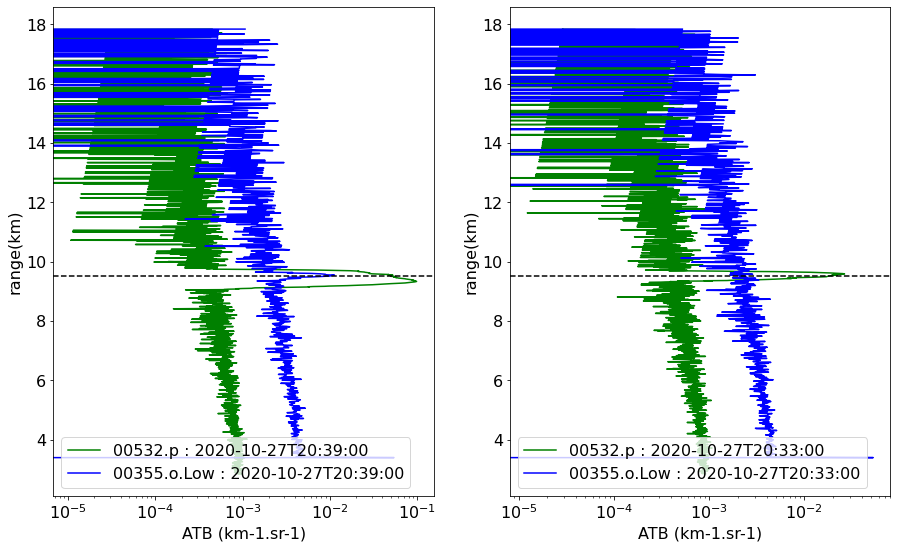

In [158]:
atb_355_bug, atb_355_mol = get_calibrated_signal_by_datetime(datetime_profile=profile532, 
                                                             lidar='LI1200', 
                                                             time_freq='1MIN', 
                                                             channel_profile='00355.o.Low')
atb_532_bug_p, atb_532_mol = get_calibrated_signal_by_datetime(datetime_profile=profile532, 
                                                             lidar='LIO3T', 
                                                             time_freq='30S', 
                                                             channel_profile='00532.p')

fig, (ax2, ax) = plt.subplots(figsize=(15,9), ncols=2)
plt.rcParams['font.size'] = '16'
plt.rcParams['axes.labelsize'] = '16'
ax.semilogx(atb_532_bug_p.values.reshape((-1,1))*1e3, atb_532_bug_p['range'], label=f'00532.p : {profile532.astype("datetime64[s]")}', color='g')
ax.semilogx(atb_355_bug.values.reshape((-1,1))*1e3, atb_355_bug['range'], label=f'00355.o.Low : {profile532.astype("datetime64[s]")}', color='b')
ax.axhline(zclouds,color='k', linestyle ="--")
ax.legend(loc='lower left')
ax.set(xlabel='ATB (km-1.sr-1)', ylabel='range(km)')

atb_355_bug, atb_355_mol = get_calibrated_signal_by_datetime(datetime_profile=profile355, 
                                                             lidar='LI1200', 
                                                             time_freq='1MIN', 
                                                             channel_profile='00355.o.Low')
atb_532_bug_p, atb_532_mol = get_calibrated_signal_by_datetime(datetime_profile=profile355, 
                                                             lidar='LIO3T', 
                                                             time_freq='1MIN', 
                                                             channel_profile='00532.p')


ax2.semilogx(atb_532_bug_p.values.reshape((-1,1))*1e3, atb_532_bug_p['range'], label=f'00532.p : {profile355.astype("datetime64[s]")}', color='g')
ax2.semilogx(atb_355_bug.values.reshape((-1,1))*1e3, atb_355_bug['range'], label=f'00355.o.Low : {profile355.astype("datetime64[s]")}', color='b')
ax2.axhline(zclouds,color='k', linestyle ="--")
ax2.legend(loc='lower left')
ax2.set(xlabel='ATB (km-1.sr-1)', ylabel='range(km)')

In [104]:
listprofilesdecales = np.array(["2020-10-27T20:33:00", "2020-03-16T19:10:00", "2019-03-11T19:53:00"],
                              dtype='datetime64[m]')
listtempsdecales = np.array(["2020-10-27T20:39:00", "2020-03-16T19:14:00", "2019-03-11T19:57:00"],
                              dtype='datetime64[m]')

[Text(0, 0.5, 'duration (m)')]

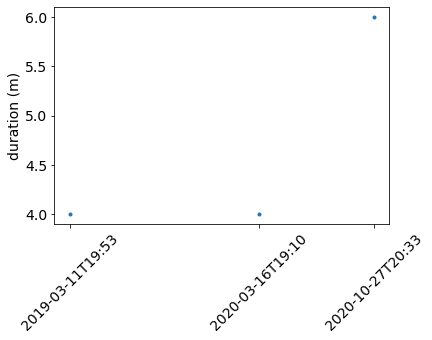

In [114]:
(listtempsdecales-listprofilesdecales)

fig, ax= plt.subplots()
ax.plot(listprofilesdecales, listtempsdecales-listprofilesdecales, '.')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
plt.xticks(rotation=45)
plt.xticks(listprofilesdecales,listprofilesdecales)
ax.set(ylabel='duration (m)')